Pendahuluan

Data Preprocessing

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [2]:
# import dataset
userData = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
loan = pd.read_csv("loan_activities.csv")
nonBorrower = pd.read_csv("non_borrower_user.csv")
submission = pd.read_csv("sample_submission.csv")


In [3]:
loanBaru = pd.DataFrame()
loanBaru["user_id"] = loan["user_id"].unique()
ts_std = loan.groupby('user_id')['ts'].std().reset_index()
loanBaru = loanBaru.merge(ts_std, on='user_id', how='left')
loanBaru.rename(columns={'ts': 'ts_std'}, inplace=True)
loan.groupby('user_id')["loan_type"].value_counts().reset_index()
loan_type_counts = loan.groupby(['user_id', 'loan_type']).size().unstack(fill_value=0).reset_index()
loanBaru = loanBaru.merge(loan_type_counts, on='user_id', how='left')

loanBaru.head()

,user_id,ts_std,1,2,3,4,5,6,7,8,9,10,11
0,2223129,209.303607,1,0,0,0,1,0,0,0,0,0,0
1,1380939,NaN,1,0,0,0,0,0,0,0,0,0,0
2,2724411,129.326460,1,0,0,0,1,1,0,0,0,0,0
3,2401751,NaN,1,0,0,0,0,0,0,0,0,0,0
4,1982168,251.147367,1,0,0,1,1,0,0,0,0,0,0


In [4]:
# merge data
dataLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index() 
nonLoan = nonBorrower.set_index('user_id').join(loan.set_index('user_id')).reset_index()
nonLoan = nonLoan.dropna() # orang yang tidak terklasifikasi sebagai peminjam tetapi pernah meminjam

# menambah data frame untuk orang di data train yang pernah meminjam
has_borrowed = dataLoan.dropna()

EDA

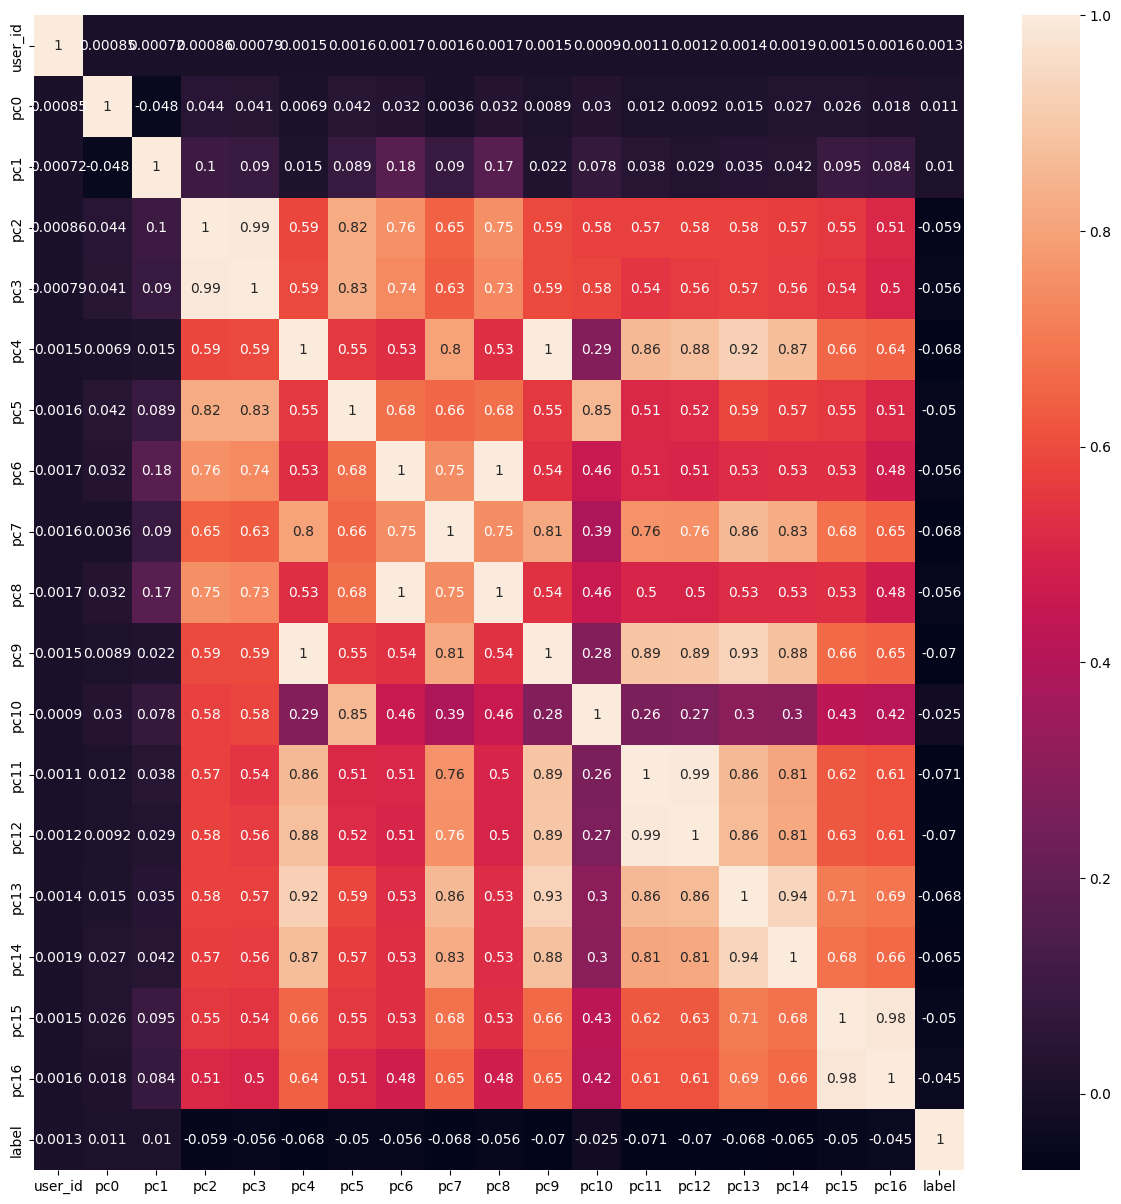

In [4]:
plt.figure(figsize=(15,15))
sns.heatmap(userData.corr(), annot=True)
plt.show()

In [5]:
#drop kolom yang sama menurut heatmap
userData = userData.drop('pc8', axis=1) 
userData = userData.drop('pc9', axis=1) 

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/1796254447.py:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/1796254447.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



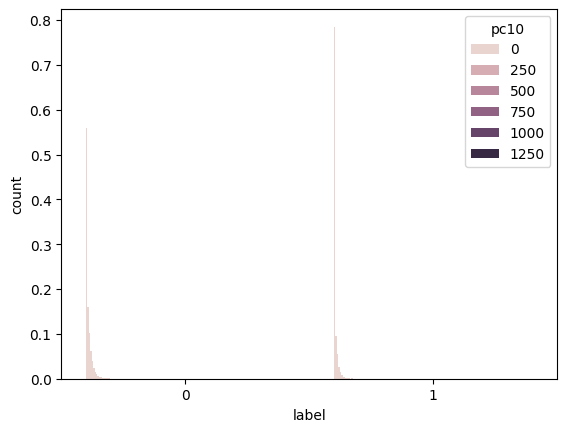

In [6]:
def categoricalAnalysis(attribute) :
    temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby([attribute], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x=attribute, hue="label", y= "count")
    plt.show()

def analysisCategorical(attribute) :
    temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby(["label"], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x="label", hue=attribute, y= "count")
    plt.show()

attribute = "pc10"
temp = userData.groupby([attribute, "label"]).count()["user_id"].reset_index()
temp.rename(columns={"user_id" : "count"}, inplace=True)
temp["count"] = temp.groupby([attribute], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

analysisCategorical("pc10")

In [7]:
temp = userData["label"].value_counts()
data = pd.DataFrame({'label': temp.index,'values': temp.values})

trace = go.Bar(
    x = data['label'],y = data['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=data['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'label', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)

iplot(fig, filename='class')

In [6]:
label_0 = has_borrowed.loc[has_borrowed['label'] == 0]["ts"]
label_1 = has_borrowed.loc[has_borrowed['label'] == 1]["ts"]

hist_data = [label_0, label_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Loan Time Stamp Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/551677038.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



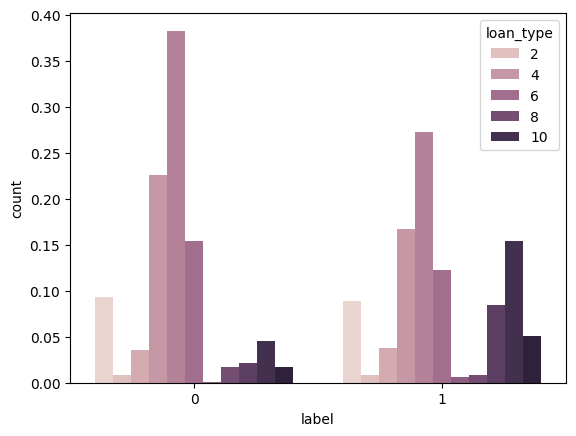

In [9]:
def analysisCategorical(attribute) :
    temp = dataLoan.groupby([attribute, "label"]).count()["user_id"].reset_index()
    temp.rename(columns={"user_id" : "count"}, inplace=True)
    temp["count"] = temp.groupby(["label"], group_keys=False).apply(lambda x: x / (x.sum()))["count"]

    sns.barplot(data= temp, x="label", hue=attribute, y= "count")
    plt.show()

analysisCategorical('loan_type')

In [10]:
tmp = dataLoan[['loan_type','label']].copy()
label_0 = tmp.loc[tmp['label'] == 0]['loan_type']
label_1 = tmp.loc[tmp['label'] == 1]['loan_type']
label_0.describe()

count    1.463095e+06
mean     4.930141e+00
std      2.078485e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      6.000000e+00
max      1.100000e+01
Name: loan_type, dtype: float64

In [11]:
label_1.describe()

count    7995.000000
mean        5.947967
std         2.855856
min         1.000000
25%         4.000000
50%         5.000000
75%         9.000000
max        11.000000
Name: loan_type, dtype: float64

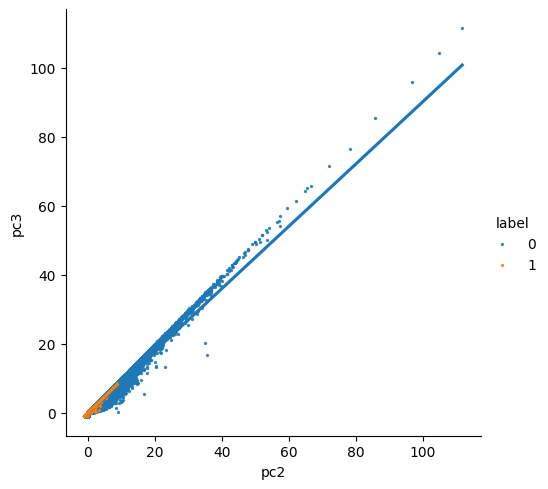

In [12]:
s = sns.lmplot(x='pc2', y='pc3',data=userData, hue='label', fit_reg=True,scatter_kws={'s':2})
plt.show()

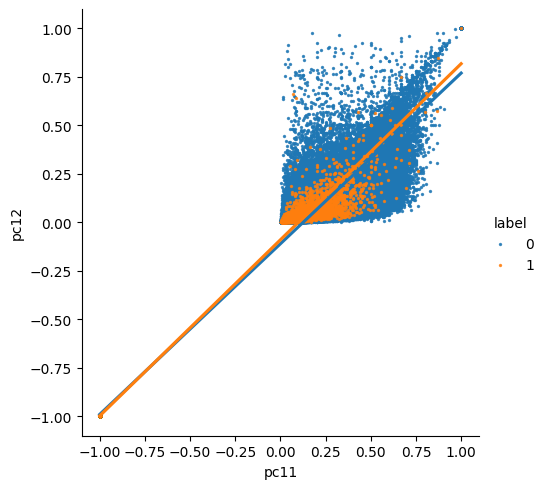

In [13]:
s = sns.lmplot(x='pc11', y='pc12',data=userData, hue='label', fit_reg=True,scatter_kws={'s':2})
plt.show()

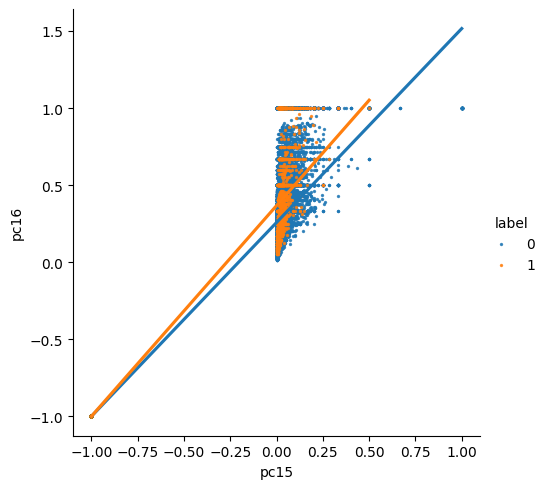

In [14]:
s = sns.lmplot(x='pc15', y='pc16',data=userData, hue='label', fit_reg=True,scatter_kws={'s':2})
plt.show()

/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/1838740921.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/1838740921.py:17: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel_9935/1838740921.py:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/var/folders/jc/cvtjm0d97vl0d6sf3px453r40000gn/T/ipykernel

<Figure size 640x480 with 0 Axes>

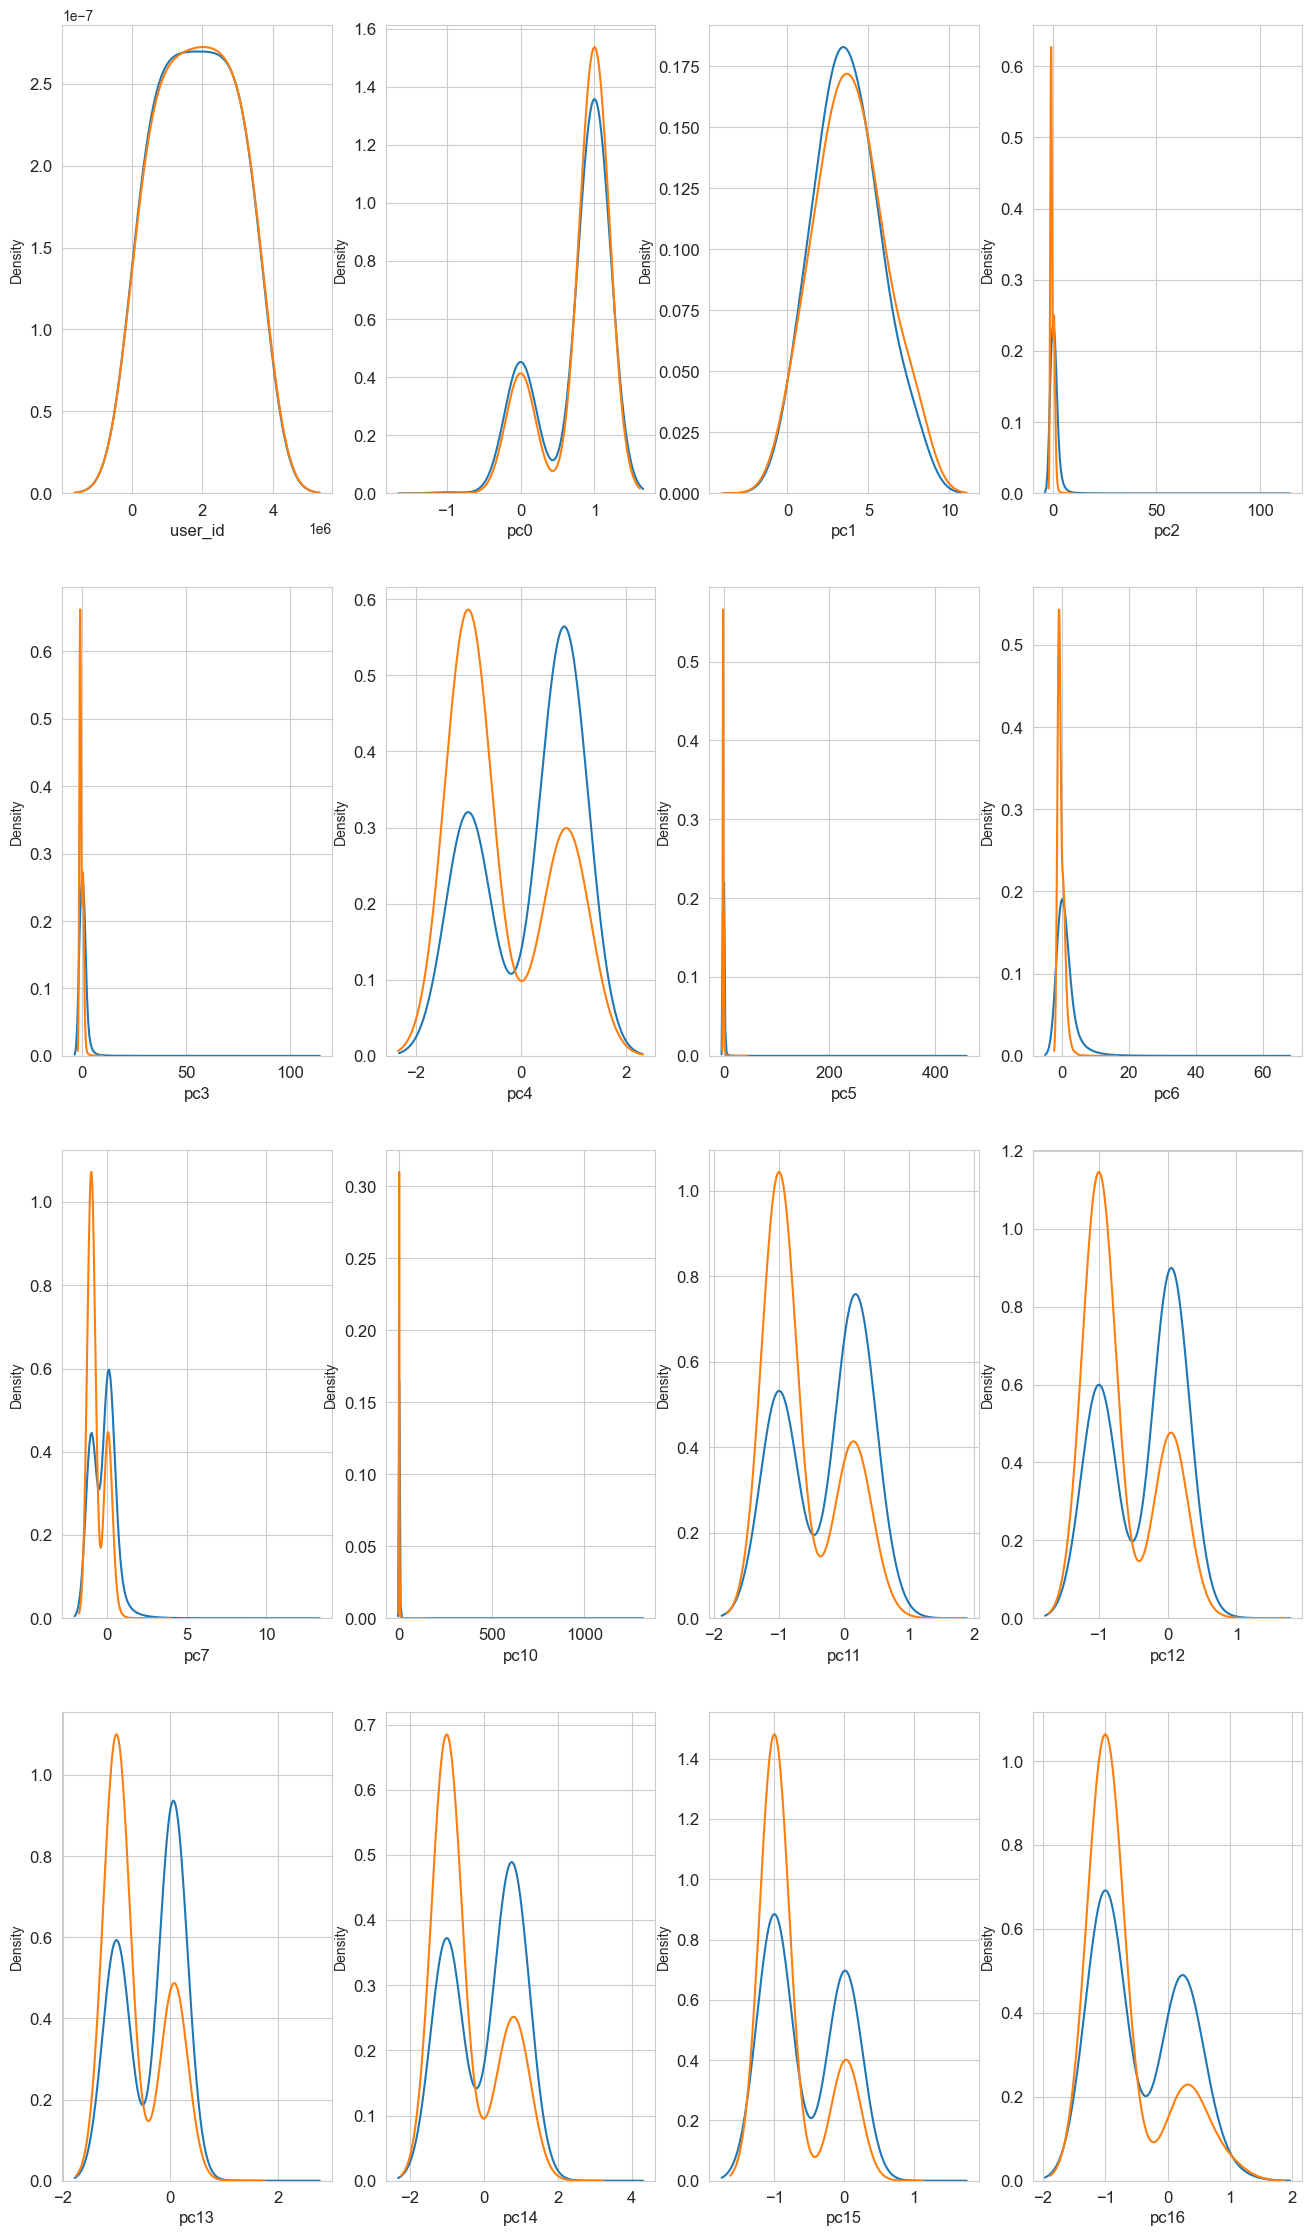

In [15]:
var = userData.columns.values
var = np.delete(var,np.where(var=="label"))


i = 0
t0 = userData.loc[userData['label'] == 0]
t1 = userData.loc[userData['label'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="label = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="label = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Feature Engineering

In [7]:
# menambah kolom
userData['-1_count'] = userData.isin([-1]).sum(axis=1) # menghitung berapa banyak missing values (-1)
userData['is_loanreference'] = userData["user_id"].isin(loan["reference_contact"]) # apakah usernya dijadiin loan reference
userData["has_borrowed"] = userData["user_id"].isin(loan["user_id"]) # apakah usernya pernah minjem
loan["referenced_is_non"] = loan["reference_contact"].isin(nonBorrower["user_id"]) # apakah reference nya non borrower
loan["referenced_is_fraud"] = loan["reference_contact"].isin(userData.loc[userData["label"] == 1]["user_id"]) #nambahin kolom apakah reference nya fraud

In [11]:
dataLoan = userData.set_index('user_id').join(loan.set_index('user_id')).reset_index()
dataLoanBaru = userData.set_index('user_id').join(loanBaru.set_index('user_id')).reset_index()

In [12]:
# memisahkan data fraud dan non fraud
loanFraud = dataLoan.loc[dataLoan["label"]==1]
loanFraud = loanFraud[["user_id", "reference_contact", "loan_type", "ts"]]
loanNonFraud = dataLoan.loc[dataLoan["label"]==0]
loanNonFraud = loanNonFraud[["user_id", "reference_contact", "loan_type", "ts"]]

In [16]:
# menambah data frame baru yang berisi info mengenai kontak referensi

referenceInfo = pd.DataFrame()
referenceInfo["user_id"] = pd.concat([userData["user_id"], (nonBorrower["user_id"]),(test["user_id"])])
referenceInfo["referenced_by_fraud"] = referenceInfo["user_id"].isin(loanFraud["reference_contact"])
referenceInfo["referenced_by_non"] = referenceInfo["user_id"].isin(loan.loc[loan.user_id.isin(nonBorrower.user_id)]["reference_contact"])
referenceInfo["referencing_fraud"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_fraud"] == 1]["user_id"])
referenceInfo["referencing_non"] = referenceInfo["user_id"].isin(loan.loc[loan["referenced_is_non"] == 1]["user_id"])
referenceInfo.loc[referenceInfo['user_id'].isin(nonBorrower["user_id"])]['label'] = None

In [21]:
# data frame yang akan digunakan untuk modelling

trainLoanReference = dataLoanBaru.set_index('user_id').join(referenceInfo.set_index('user_id')).reset_index() #nyatuin data train sama loan
trainLoanReference.rename(columns={"label_train" : "label"}, inplace=True)
trainLoanReference.fillna(0, inplace=True)  

In [22]:
trainLoanReference.columns

Index([            'user_id',                 'pc0',                 'pc1',
                       'pc2',                 'pc3',                 'pc4',
                       'pc5',                 'pc6',                 'pc7',
                      'pc10',                'pc11',                'pc12',
                      'pc13',                'pc14',                'pc15',
                      'pc16',               'label',            '-1_count',
          'is_loanreference',        'has_borrowed',              'ts_std',
                           1,                     2,                     3,
                           4,                     5,                     6,
                           7,                     8,                     9,
                          10,                    11, 'referenced_by_fraud',
         'referenced_by_non',   'referencing_fraud',     'referencing_non'],
      dtype='object')